In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import random

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

# import hyperparameters
from cbrcnn_hyperparams import *
# from model import BRNN
# from utils import load_dataset, get_num_class

import numpy as np

# processing bar
from tqdm import tqdm

# plots
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# 
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'{model_name}board_test')

### Note!
#### Model structure
**Stage 1**

Input Sequence --> BRNN --> Conv (kernel_size 7) --> *Tanh* --> Conv (kernel_size 1) --> *Softmax* --> Output


**Segmentation**

!!! segment expression 1 & 2 are the same meaning.

****
1. segment expression 1 \
size_of_a_segment = 21 \
num_segments = 15 \
****
2. segment expression 2 \
num_of_the_segments [Cseg] = 10 \
size_of_the_segments [Cwin] = 7




**Stage 2**

Stage1_seg --> BRNN --> Conv (kernel_size 7) --> *Tanh* --> Conv (kernel_size 1) --> *Softmax* --> Output

#### Data batch
pack_padded_sequence -- BRNN

pad_packed_sequence -- CNN

****

### logging

In [2]:
import logging
logging.root.setLevel(logging.INFO)
# logging.basicConfig(level=logging.NOTSET)
logging.basicConfig(filename=log_name+'_test', 
                    filemode='a',
                    format='%(asctime)s %(message)s', 
                    datefmt='%m/%d/%Y %I:%M:%S %P',
                    level=logging.INFO)

In [3]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.warning('Device: ' + device.type)
device

device(type='cuda')

### Test hyperpramas

In [200]:
batch_size = 4
num_epochs = 100
train_fpath = root_path + '/data/train'
test_fpath = root_path + '/data/test'

## Utils

In [201]:
def load_dataset(fpath):
    '''
    params:
        fpath - path to fasta file, training or test
                ***The format of the sets:

                The first two lines are a global header:
                total_number_of_records
                input_size number_of_classes

                total_number_of_records is simply the number of proteins in the set,
                input_size is how many numbers are used to represent one amino acid (21
                or 22, probably, in your case) and number_of_classes is the number of
                classes...

                After that you have the proteins, 5 lines each:

                line 1: name of the protein
                line 2: number of amino acids in the protein
                line 3: input
                line 4: targets
                line 5: empty

                You can use any name you want so long as it's unique, a single word, and
                not outrageously long.

                The input should be a single long list of the numbers representing the
                amino acids in the protein. If you use, say, 21 numbers per amino acid,
                and the protein is 100 amino acids long, the input line will contain
                2100 numbers, with the first 21 being the representation of the first
                amino acid in the protein, the following 21 the representation of the
                second, etc.
                For the moment (before we use alignments) the representation of an amino
                acid will be a one-hot encoding, e.g.:

                A     -> 1 0 0 0 ..... 0 0
                C     -> 0 1 0 0 ..... 0 0
                ...
                Y     -> 0 0 0 0 ..... 1 0
                other -> 0 0 0 0 ..... 0 1

                where "other" is unknown or weird amino acid (X, B, J, O, U, Z)

                The line containing the targets is a list of integers representing the
                classes of the amino acids. There are as many integers as there are
                amino acids in the protein. You can choose whatever integers you want,
                but it's probably simplest to have something like class1=0, class2=1,
                class3=2, etc..

                (notice that in the sample sets in the directory you have a more
                complicated representation of the inputs, where there are a lot of
                floating point numbers rather than just 0 and 1, and that's because
                those inputs are frequency profiles from MSA - so you can see how the
                code works for both kinds of inputs)
                
    returns:
        p_data - list[data_tensor, target_tensor]
        p_lens - list, protein length
    
    Note: 
        - the reason not using tensor to save protein Sequences and Targets is we have varying length sequences! 
        - solve this problem we could consider pading. But our dataset lens range from about 20 to 10,000. 
            Thus, padding maybe not a good idea here.
        - to solve variance sequences problem, we can use pad_sequence, pack_padded_sequence & 
    '''
    num_protein = 0
    num_i = 0
    num_o = 0

    # p_names = []
    p_lens = []
    # p_seqs = []
    # p_anns = []
    p_data = []
    with open(fpath) as fp:
        num_protein = int(fp.readline())
        num_io = fp.readline().split(' ')
        num_i = int(num_io[0])
        num_o = int(num_io[0])

        line = fp.readline()
        while line:
            # p_name = line[:-1]
            p_len = int(fp.readline())
            p_sequence = torch.tensor([int(x) for x in fp.readline().split(' ')], 
                                      dtype=torch.float32).reshape(-1, 21)
            p_annotation = torch.tensor([[int(x)] for x in fp.readline().split(' ')], dtype=torch.float32)
            # skip empty
            next(fp)
            # p_names.append(p_name)
            p_lens.append(p_len)
            # p_seqs.append(p_sequence)
            # p_anns.append(p_annotation)
            p_data.append([p_sequence, p_annotation])
            line = fp.readline()   
    return p_data, p_lens


In [202]:
class ProteinDataset(Dataset):
    
    def __init__(self, fpath, transform=None):
        self.p_data, self.p_lens = load_dataset(fpath)
    
    def __len__(self) -> int:
        return len(self.p_lens)
    
    def __getitem__(self, i) -> torch.Tensor:
        # self.p_data[i][0], sequence;  self.p_data[i][1], label
        return self.p_data[i][0], self.p_data[i][1]
    def numAAs(self) -> int:
        return sum(self.p_lens)

In [203]:
def pad_packed_collate(batch):
    """Puts data, and lengths into a packed_padded_sequence then returns
       the packed_padded_sequence and the labels. Set use_lengths to True
       to use this collate function.
       Args:
         batch: (list of tuples) [(sequence, target)].
             sequence is a FloatTensor
             target has the same variable length with sequence
       Output:
         packed_batch: (PackedSequence), see torch.nn.utils.rnn.pack_padded_sequence
         labels: (Tensor), labels from the file names of the wav.
    """

    if len(batch) == 1:
        seqs, labels = [batch[0][0]], [batch[0][1]]
        lengths = [seqs[0].size(0)]
        
    if len(batch) > 1:
        # get data and sorted by the length of sequence
        seqs, labels, lengths = zip(*[(a, b, a.size(0)) for (a,b) in sorted(batch, key=lambda x: x[0].size(0), reverse=True)])
    seqs = pad_sequence(seqs, batch_first=True)
    labels = pad_sequence(labels, batch_first=True)
    packed_seqs = pack_padded_sequence(seqs, lengths, batch_first=True)
    packed_labels = pack_padded_sequence(labels, lengths, batch_first=True)
    
    return packed_seqs, packed_labels


In [204]:
def rocPlot(train_label, train_probs, val_label, val_probs):
    fig = plt.figure(figsize=(8, 8))
    
    t_fpr, t_tpr, t_thresholds = roc_curve(train_label, train_probs)
    t_roc_auc = auc(t_fpr, t_tpr)
    v_fpr, v_tpr, v_thresholds = roc_curve(val_label, val_probs)
    v_roc_auc = auc(v_fpr, v_tpr)
    
    lw = 2
    plt.plot(
        t_fpr,
        t_tpr,
        color="darkorange",
        lw=lw,
        label="Training (area = %0.2f)" % t_roc_auc,
    )
    
    plt.plot(
        v_fpr,
        v_tpr,
        color="darkgreen",
        lw=lw,
        label="Val (area = %0.2f)" % v_roc_auc,
    )
    
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(model_name+": Train & Val ROC curve")
    plt.legend(loc="lower right")
    
    plt.show()
    return fig

### Segmentation

In [205]:
def seqSegment(seq, Cseq=10, Cwin=7, len_encoding=15):
    '''
    Input:
        seq: pytorch tensor, size [batch_size, sequence_length]
        Cseq=10: segment size is 21
        Cwin=7: the number of segments is 15
        len_encoding: is the number of final segments, which equal to the number of features of the Stage2 input.
        
    Funtion:
        for each element/stage1_prediction 
    
    Output:
       segments 
    '''
    # convert torch Tensor to numpy array
    seq = seq.detach().numpy()
    len_seq = seq.shape[1]
    batch_size = seq.shape[0]
    num_padding = Cseq
    win_size = num_padding*2+1
    input_segment = np.empty((batch_size, len_seq, len_encoding), dtype=float)
    
    # Here, 1 means the num of features. 
    # The output of stage1 has only 1 feature [values between in 0/order to 1/disorder]
    pad_zeros = [0] * 1 * num_padding
    
    for b in range(batch_size):
        s = list(seq[0])
        s_with_padding = []
        
        s_with_padding = s_with_padding + pad_zeros
        s_with_padding = s_with_padding + s
        s_with_padding = s_with_padding + pad_zeros
        
        for i in range(len_seq):
            # note, len_encoding = win_size - (Cwin-1)
            input_segment[b][i] = [np.mean(s_with_padding[(i+j): (i+j+Cwin)]) for j in range(len_encoding)]
    input_segment = torch.from_numpy(input_segment)
    input_segment = input_segment.float()
    return input_segment

## Dataset

In [206]:
# !!!!
# file need extra one empty line
# !!!!
logging.warning('Loading training file ...')
train_ds = ProteinDataset(train_fpath)
logging.warning('Loading test file ...')
test_ds = ProteinDataset(test_fpath)

In [207]:
train_ds.p_data[0][1].size()

torch.Size([208, 1])

In [208]:
# dataloader
# using pad_packed_collate to deal with padding
train_dl = DataLoader(train_ds, batch_size = batch_size, num_workers = 72, shuffle=True, collate_fn=pad_packed_collate)
test_dl = DataLoader(test_ds, batch_size = 1, num_workers = 72, shuffle=False, collate_fn=pad_packed_collate)


In [209]:
logging.warning('Training set: ' + str(len(train_ds.p_lens)))
logging.warning('Test set:     ' + str(len(test_ds.p_lens)))

In [210]:
# for batch_idx, (data, label) in enumerate(train_dl):
#     print(data.batch_sizes[0])

a = 0

## Model

In [211]:
# set device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CBRCNNStage1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropP = 0):
        super(CBRCNNStage1, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                         bidirectional=True)
        # self.fc = nn.Linear(hidden_size*2, 1)
        
        self.conv11 = nn.Conv2d(in_channels=1, out_channels=1, 
                               kernel_size=(7, hidden_size*2),
                              stride = 1, padding=(3, 0))
        
#         self.conv12 = nn.Conv2d(in_channels=7, out_channels=1, 
#                                kernel_size=(3, 3),
#                               stride = 1, padding=(1, 1))
        
        self.conv12 = nn.Conv1d(in_channels=1, out_channels=1,
                              kernel_size=1, stride=1, 
                               padding=0)
        
        self.sigmoid = nn.Sigmoid()
        self.drop = nn.Dropout(p = dropP)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.batch_sizes[0], self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers*2, x.batch_sizes[0], self.hidden_size).to(device)
        # Forward Prop
        # out, (hn, cn) = self.lstm(x,  (h0, c0))
        # out, _ = self.lstm(x,  (h0, c0))
        packed_out, (hn, cn) = self.lstm1(x,  (h0, c0))
        cx, _ = pad_packed_sequence(packed_out, batch_first=True)
        # all training example, last hidden state, all 
        # it is not last hidden state, it is the last batch
        # print('out.squeeze() ', out.squeeze().size())
        # out = self.fc(out)
        
        cx = torch.tanh(self.conv11(torch.unsqueeze(cx, 1)))
        
        out = self.conv12(cx.squeeze(3)) 
        out = self.drop(out)
        out = self.sigmoid(out)
        return out

In [212]:
class CBRCNNStage2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropP = 0):
        super(CBRCNNStage2, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                         bidirectional=True)
        # self.fc = nn.Linear(hidden_size*2, 1)
        
        self.conv11 = nn.Conv2d(in_channels=1, out_channels=1, 
                               kernel_size=(7, hidden_size*2),
                              stride = 1, padding=(3, 0))
        
#         self.conv12 = nn.Conv2d(in_channels=7, out_channels=1, 
#                                kernel_size=(3, 3),
#                               stride = 1, padding=(1, 1))
        
        self.conv12 = nn.Conv1d(in_channels=1, out_channels=1,
                              kernel_size=1, stride=1, 
                               padding=0)
        
        self.sigmoid = nn.Sigmoid()
        self.drop = nn.Dropout(p = dropP)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        # Forward Prop
        # out, (hn, cn) = self.lstm(x,  (h0, c0))
        # out, _ = self.lstm(x,  (h0, c0))
        cx, (hn, cn) = self.lstm1(x,  (h0, c0))
        # cx, _ = pad_packed_sequence(packed_out, batch_first=True)
        # all training example, last hidden state, all 
        # it is not last hidden state, it is the last batch
        # print('out.squeeze() ', out.squeeze().size())
        # out = self.fc(out)
        cx = torch.tanh(self.conv11(torch.unsqueeze(cx, 1)))
        
        out = self.conv12(cx.squeeze(3)) 
        out = self.drop(out)
        out = self.sigmoid(out)
        return out

In [213]:
def train_batch(stage1, stage2, train_loader, optimizerStage1, optimizerStage2, criterion):
    # set training state to model
    stage1.to(device)
    stage2.to(device)
    
    stage1.train()
    stage2.train()

    with tqdm(total=len(train_loader), position=0) as progress_bar:
        for batch_idx, (data, label) in enumerate(train_loader): 
            ###
            # Stage 1 Training
            ###
            data = data.to(device)
            label = label.to(device)
            
            # forward
            optimizerStage1.zero_grad()
            output1 = stage1(data)
            output1 = output1.squeeze(1) # output shape: [batch_size, len_sequence]
            
            label, _ = pad_packed_sequence(label, batch_first=True)
            label = label.squeeze(2) # label shape: [batch_size, len_sequence]
            
            # update weights
            loss1 = criterion(output1, label)
            loss1.backward()
            optimizerStage1.step()
            
            ###
            # Stage 1 Training
            ###
            
            # first, process the input for stage 2
            # Input: segments based on the output of Stage 1
            # Output/Target: stay the same with Stage 1
            
            # Segmentation
            output1 = output1.cpu()
            s2_data = seqSegment(output1).to(device)
            
            # forward
            optimizerStage2.zero_grad()
            output2 = stage2(s2_data)
            output2 = output2.squeeze(1) # output shape: [batch_size, len_sequence]
            
            # update weights
            loss2 = criterion(output2, label)
            loss2.backward()
            optimizerStage2.step()
            
            progress_bar.update(1)

def val_batch(stage1, stage2, val_data, criterion): 
    # set evaluation state to the model
    stage1.to(device)
    stage2.to(device)
    stage1.eval()
    stage2.eval()
    
    s1_losses = []
    s2_losses = []

    s1_class_probs = []
    s2_class_probs = []
    
    class_label = []

    # no gradient needed
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_data):
            data = data.to(device)
            target = target.to(device)
            # forward
            scores1 = stage1(data)
            scores1 = scores1.squeeze(1)

            target, _ = pad_packed_sequence(target, batch_first=True)
            target = target.squeeze(2) # label shape: [batch_size, len_sequence]
            
            loss1 = criterion(scores1, target)
            # ERROR
            s1_losses.append(loss1.cpu()) # loss for each batch
            
            # save for ploting curve
            s1_class_probs.append(scores1.squeeze(-1).cpu())
            class_label.append(target.cpu())
            
            
            # Segmentation
            scores1 = scores1.cpu()
            s2_data = seqSegment(scores1).to(device)
            
            # forward
            scores2 = stage2(s2_data)
            scores2 = scores2.squeeze(1) # output shape: [batch_size, len_sequence]
            
            # update weights
            loss2 = criterion(scores2, target)
            
            # ERROR
            s2_losses.append(loss2.cpu()) # loss for each batch
            
            # save for ploting curve
            s2_class_probs.append(scores2.squeeze(-1).cpu())

    # overall loss
    s1_loss = np.mean(s1_losses)
    s2_loss = np.mean(s2_losses)
    return s1_loss, s2_loss, s1_class_probs, s2_class_probs, class_label

## Initialization

In [214]:
# init model
modelStage1 = CBRCNNStage1(input_size, hidden_size, num_layers, num_classes, dropP)
modelStage2 = CBRCNNStage2(input_size_stage2, hidden_size_stage2, num_layers, num_classes, dropP)

# propogation of two classes

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()

optimizerStage1 = optim.Adam(modelStage1.parameters(), lr=learning_rate)
optimizerStage2 = optim.Adam(modelStage2.parameters(), lr=learning_rate)

## Training

100%|████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]


Training [Stage 1]: Loss:
0.80566347
Training [Stage 2]: Loss:
0.7393502
VAL [Stage 1]: Loss:
0.77197653
VAL [Stage 2]: Loss:
0.72968245


Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/qinqin/anaconda3/envs/py37/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/qinqin/anaconda3/envs/py37/lib/python3.7/site-packages/tensorboard/summary/writer/event_file_writer.py", line 233, in run
    self._record_writer.write(data)
  File "/home/qinqin/anaconda3/envs/py37/lib/python3.7/site-packages/tensorboard/summary/writer/record_writer.py", line 40, in write
    self._writer.write(header + header_crc + data + footer_crc)
  File "/home/qinqin/anaconda3/envs/py37/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/io/gfile.py", line 766, in write
    self.fs.append(self.filename, file_content, self.binary_mode)
  File "/home/qinqin/anaconda3/envs/py37/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/io/gfile.py", line 160, in append
    self._write(filename, file_content, "ab" if binary_mode else "a")
  File "/home/qinqin/anaconda3/envs/py37

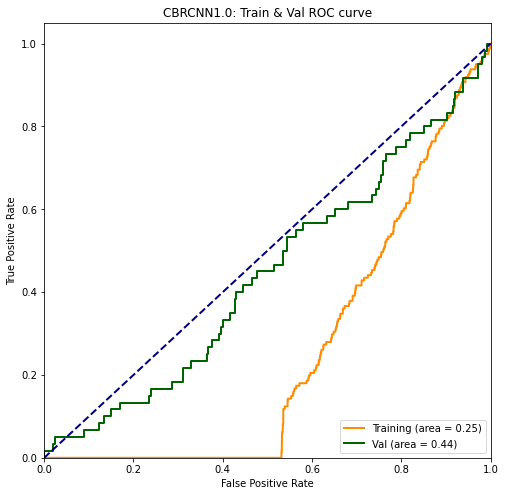

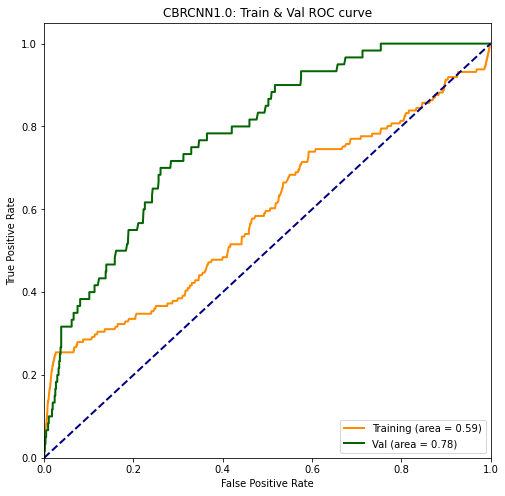

100%|████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]


Training [Stage 1]: Loss:
0.79166293
Training [Stage 2]: Loss:
0.6780599
VAL [Stage 1]: Loss:
0.7566632
VAL [Stage 2]: Loss:
0.6808382


100%|████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]


Training [Stage 1]: Loss:
0.7866834
Training [Stage 2]: Loss:
0.620689
VAL [Stage 1]: Loss:
0.7407959
VAL [Stage 2]: Loss:
0.6362103


100%|████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]


Training [Stage 1]: Loss:
0.77093995
Training [Stage 2]: Loss:
0.57181
VAL [Stage 1]: Loss:
0.72423685
VAL [Stage 2]: Loss:
0.59702533


  0%|                                                                        | 0/2 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [215]:
logging.warning(f"model_name: {model_name} \n \
                batch_size: {batch_size} \n \
                num_epochs: {num_epochs} \n \
                learning_rate: {learning_rate}")

for epoch in range(num_epochs):
    logging.warning('*********************************')
    logging.warning('epoch: ' + str(epoch))
    logging.warning('*********************************')
    ################
    # 3.1. Training
    ################
    logging.warning('1. TRAINING:')
    # plot pr and roc curve or not
    plot_pr_roc = (epoch % plot_nEpoch == 0)

    # training
    train_batch(modelStage1, modelStage2, train_dl, optimizerStage1, optimizerStage2, criterion)
    
    # acc & loss
    train_loss_s1, train_loss_s2, t_class_probs_s1, t_class_probs_s2, t_class_label = val_batch(modelStage1, modelStage2, train_dl, criterion)
    val_loss_s1, val_loss_s2, v_class_probs_s1, v_class_probs_s2, v_class_label = val_batch(modelStage1, modelStage2, test_dl, criterion)
    
    # val_accs.append(val_acc)
    
    print('Training [Stage 1]: Loss:')
    print(train_loss_s1)
    
    print('Training [Stage 2]: Loss:')
    print(train_loss_s2)
    
    print('VAL [Stage 1]: Loss:')
    print(val_loss_s1)
    
    print('VAL [Stage 2]: Loss:')
    print(val_loss_s2)
    
    logging.warning('Training:')
    logging.warning(f'Loss s1, s2: {train_loss_s1}, {train_loss_s2}')

    logging.warning('Validation:')
    logging.warning(f'Loss s1, s2: {val_loss_s1}, {val_loss_s2}')
    
    ##
    # for tensorboard plots
    ##
    writer.add_scalars("TRAIN & VAL Loss", {'TRAIN S1': train_loss_s1,
                                            'TRAIN S2': train_loss_s2,
                                           'VAL S1': val_loss_s1,
                                           'VAL S2': val_loss_s2}, epoch)
    
    train_probs_s1 = torch.cat([batch.reshape(-1) for batch in t_class_probs_s1])
    train_probs_s2 = torch.cat([batch.reshape(-1) for batch in t_class_probs_s2])
    train_label = torch.cat([lab.reshape(-1) for lab in t_class_label])
    
    val_probs_s1 = torch.cat([batch.reshape(-1) for batch in v_class_probs_s1])
    val_probs_s2 = torch.cat([batch.reshape(-1) for batch in v_class_probs_s2])
    val_label = torch.cat([lab.reshape(-1) for lab in v_class_label])
    
    writer.add_scalars("AUC Score", {'TRAIN S1': roc_auc_score(train_label, train_probs_s1, average=None),
                                     'TRAIN S2': roc_auc_score(train_label, train_probs_s2, average=None),
                                    'VAL S1': roc_auc_score(val_label, val_probs_s1, average=None),
                                    'VAL S2': roc_auc_score(val_label, val_probs_s2, average=None)}, epoch)
    
    ##
    # PR-curve & ROC-curve
    ##
    
    if plot_pr_roc:
        writer.add_pr_curve(f'TRAIN S1: pr_curve e{epoch}', train_label, train_probs_s1, 0)
        writer.add_pr_curve(f'VAL S1: pr_curve e{epoch}', val_label, val_probs_s1, 0)
        
        writer.add_pr_curve(f'TRAIN S2: pr_curve e{epoch}', train_label, train_probs_s2, 0)
        writer.add_pr_curve(f'VAL S2: pr_curve e{epoch}', val_label, val_probs_s2, 0)

        roc_fig_s1 = rocPlot(train_label, train_probs_s1, val_label, val_probs_s1)
        roc_fig_s2 = rocPlot(train_label, train_probs_s2, val_label, val_probs_s2)
        writer.add_figure(f'[Stage 1] Train vs VAL: roc_curve e{epoch}', roc_fig_s1)
        writer.add_figure(f'[Stage 2] Train vs VAL: roc_curve e{epoch}', roc_fig_s2)
    
    ##
    # Save model every m epochs
    ##
    if epoch % checkpoint_m == 0:
        # Stage 1 model
        cPATH_s1 = f"checkpoint/{model_name}_s1_{epoch}.pth"
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': modelStage1.state_dict(),
                    'optimizer_state_dict': optimizerStage1.state_dict(),
                    'loss': train_loss_s1,
                    }, cPATH_s1)
        
        # Stage 2 model
        cPATH_s2 = f"checkpoint/{model_name}_s2_{epoch}.pth"
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': modelStage2.state_dict(),
                    'optimizer_state_dict': optimizerStage2.state_dict(),
                    'loss': train_loss_s2,
                    }, cPATH_s2)
        
logging.warning(f"model_name: {model_name}_s1&S2 \n \
                batch_size: {batch_size} \n \
                 num_epochs: {num_epochs} \n \
                learning_rate: {learning_rate} \n ")
                # best_val_epoch: {int(np.argmax(val_accs)+1)}") # the best val epoch

writer.flush()
writer.close()

In [ ]:
data

In [ ]:
a.detach().numpy().shape

In [150]:
b = seqSegment(a)
a.size(), b.size()

(torch.Size([1, 817]), torch.Size([1, 817, 15]))

In [151]:
b

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.5521, 0.5513, 0.5513],
         [0.0000, 0.0000, 0.0000,  ..., 0.5513, 0.5513, 0.5507],
         [0.0000, 0.0000, 0.0808,  ..., 0.5513, 0.5507, 0.5498],
         ...,
         [0.5503, 0.5504, 0.5508,  ..., 0.0806, 0.0000, 0.0000],
         [0.5504, 0.5508, 0.5509,  ..., 0.0000, 0.0000, 0.0000],
         [0.5508, 0.5509, 0.5514,  ..., 0.0000, 0.0000, 0.0000]]],
       dtype=torch.float64)

In [ ]:
torch.unsqueeze(x, 0).size()

In [ ]:
torch.unsqueeze(x, 1).size()

In [65]:
print(model)

BRNN(
  (lstm): LSTM(21, 24, num_layers=4, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=48, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [51]:
from torchinfo import summary

seq_len = 2000
summary(model, input_size=(1, seq_len, 21))

h0:  torch.Size([4, 1, 24])
c0:  torch.Size([4, 1, 24])
out:  torch.Size([1, 2000, 48])
hn:  torch.Size([4, 1, 24])
cn:  torch.Size([4, 1, 24])
out.squeeze()  torch.Size([2000, 48])
out final:  torch.Size([2000, 1])


Layer (type:depth-idx)                   Output Shape              Param #
BRNN                                     [2000, 1]                 --
├─LSTM: 1-1                              [1, 2000, 48]             23,232
├─Linear: 1-2                            [2000, 1]                 49
├─Sigmoid: 1-3                           [2000, 1]                 --
Total params: 23,281
Trainable params: 23,281
Non-trainable params: 0
Total mult-adds (M): 46.56
Input size (MB): 0.17
Forward/backward pass size (MB): 0.78
Params size (MB): 0.09
Estimated Total Size (MB): 1.05

## Test pad_sequence & pack_padded_sequence & pad_packed_sequence
### 1. pad_sequence

In [161]:
a = [torch.tensor([[1,2,3], [2,3,4], [4,5,6]]), torch.tensor([[3,4, 5]])]
a_pad = torch.nn.utils.rnn.pad_sequence(a, batch_first=True)

b = [torch.tensor([1,2,3]), torch.tensor([3,4])]
b_pad = torch.nn.utils.rnn.pad_sequence(b, batch_first=True)

In [162]:
a

[tensor([[1, 2, 3],
         [2, 3, 4],
         [4, 5, 6]]),
 tensor([[3, 4, 5]])]

In [163]:
a_pad

tensor([[[1, 2, 3],
         [2, 3, 4],
         [4, 5, 6]],

        [[3, 4, 5],
         [0, 0, 0],
         [0, 0, 0]]])

In [164]:
b

[tensor([1, 2, 3]), tensor([3, 4])]

In [83]:
b_pad

tensor([[1, 2, 3],
        [3, 4, 0]])

### pack_padded_sequence

In [84]:
a_pack = torch.nn.utils.rnn.pack_padded_sequence(a_pad, batch_first=True, lengths=[3,1])
a_pack

PackedSequence(data=tensor([[1, 2, 3],
        [3, 4, 5],
        [2, 3, 4],
        [4, 5, 6]]), batch_sizes=tensor([2, 1, 1]), sorted_indices=None, unsorted_indices=None)

In [85]:
b_pack = torch.nn.utils.rnn.pack_padded_sequence(b_pad, batch_first=True, lengths=[3,2])
b_pack

PackedSequence(data=tensor([1, 3, 2, 4, 3]), batch_sizes=tensor([2, 2, 1]), sorted_indices=None, unsorted_indices=None)

### pad_packed_sequence

In [86]:
a_reverse_pack = torch.nn.utils.rnn.pad_packed_sequence(a_pack, batch_first=True)
a_pad, a_reverse_pack


(tensor([[[1, 2, 3],
          [2, 3, 4],
          [4, 5, 6]],
 
         [[3, 4, 5],
          [0, 0, 0],
          [0, 0, 0]]]),
 (tensor([[[1, 2, 3],
           [2, 3, 4],
           [4, 5, 6]],
  
          [[3, 4, 5],
           [0, 0, 0],
           [0, 0, 0]]]),
  tensor([3, 1])))

In [87]:
b_reverse_pack = torch.nn.utils.rnn.pad_packed_sequence(b_pack, batch_first=True)
b_pad, b_reverse_pack

(tensor([[1, 2, 3],
         [3, 4, 0]]),
 (tensor([[1, 2, 3],
          [3, 4, 0]]),
  tensor([3, 2])))

## Note
### 1. pad_sequence does not sort sequence by seq_len

In [88]:
from torch.nn.utils.rnn import pad_sequence
c = [torch.ones(5, 10), torch.ones(7, 10), torch.ones(3, 10)]
c_pad = pad_sequence(c, batch_first=True)
c_pad

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0

### 2. but pack_padded_sequence wants a sorted pad_result

In [89]:
c_pack = torch.nn.utils.rnn.pack_padded_sequence(c_pad, batch_first=True, lengths=[5,7,3])
c_pack

RuntimeError: `lengths` array must be sorted in decreasing order when `enforce_sorted` is True. You can pass `enforce_sorted=False` to pack_padded_sequence and/or pack_sequence to sidestep this requirement if you do not need ONNX exportability.

### 3. set enforce_sorted=False or padding manuly

In [95]:
c_pack = torch.nn.utils.rnn.pack_padded_sequence(c_pad, batch_first=True, lengths=[5,7,3], enforce_sorted=False)
c_pack


PackedSequence(data=tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), batch_sizes=tensor([3, 3, 3, 2, 2, 1, 1]), sorted_indices=tensor([1, 0, 2]), unsorted_indices=tensor([1, 0, 2]))

### 4. sorted_indices & unsorted_indices are not none only if enforce_sorted=False